In [1]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
from collections import OrderedDict
import cv2
import copy
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from skimage.transform import resize
from skimage.color import rgb2gray

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.config import CfgNode as CN
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.data.datasets import load_coco_json
from detectron2.engine import DefaultTrainer, DefaultPredictor, default_argument_parser, default_setup, launch
from detectron2.evaluation import inference_on_dataset, COCOEvaluator
from detectron2.modeling import build_model
from detectron2.utils.events import EventStorage
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import scene_generation.inverse_graphics.synthetic_scene_database_loader as loader
from scene_generation.inverse_graphics.synthetic_scene_database_loader import XenRCNNMapper
import scene_generation.inverse_graphics.keypoint_mcmc.roi_heads as roi_heads

np.set_printoptions(precision=2)
torch.set_default_tensor_type(torch.FloatTensor)

DATA_ROOT = "/home/gizatt/data/generated_cardboard_envs/"
DETECTRON_ROOT = "/home/gizatt/tools/detectron2/"

%matplotlib inline
def cv2_imshow(im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')

/home/gizatt/projects/scene_generation/inverse_graphics/synthetic_scene_database_loader.py:24: _DrakeImportWarning: 
You may have already (directly or indirectly) imported `torch` which uses
`RTLD_GLOBAL`. Using `RTLD_GLOBAL` may cause symbol collisions which manifest
themselves in bugs like "free(): invalid pointer". Please consider importing
`pydrake` (and related C++-wrapped libraries like `cv2`, `open3d`, etc.)
*before* importing `torch`. For more details, see:
https://github.com/pytorch/pytorch/issues/3059#issuecomment-534676459

  from scene_generation.utils.type_convert import (


In [2]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from scene_generation.inverse_graphics.synthetic_scene_database_loader import load_xencoco_json

DatasetCatalog.clear()
def load_dataset(d):
    return load_xencoco_json(
        os.path.join(DATA_ROOT, "%s.json" % (d)),
        data_root=DATA_ROOT,
        dataset_name="synthetic_%s" % d)
def load_real_dataset():
    return load_coco_json(
        "/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json",
        image_root="/home/gizatt/data/coco/cardboard_boxes_in_wild/images",
        dataset_name="prime_boxes_real", extra_annotation_keys=None)
for d in ["train", "test"]:
    DatasetCatalog.register("synthetic_" + d, lambda d=d: load_dataset(d))
DatasetCatalog.register("prime_boxes_real", load_real_dataset)
synthetic_train_metadata = MetadataCatalog.get("synthetic_train")
real_prime_boxes_metadata = MetadataCatalog.get("prime_boxes_real")
real_prime_boxes_metadata.set(json_file="/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json")
print("Metadata train: ", synthetic_train_metadata)
print("Metadata real: ", real_prime_boxes_metadata)
DatasetCatalog.register("synthetic_5_types", lambda: load_dataset("scene_groups_5_types"))

Metadata train:  Metadata(name='synthetic_train')
Metadata real:  Metadata(json_file='/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json', name='prime_boxes_real')


In [3]:
cfg = get_cfg()
cfg.merge_from_file(os.path.join(DETECTRON_ROOT, "configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.INPUT.MIN_SIZE_TRAIN = (480)
cfg.INPUT.MIN_SIZE_TEST = (480)
cfg.INPUT.DEPTH_FORMAT = 'L'
cfg.DATALOADER.ASPECT_RATIO_GROUPING = False

cfg.DATASETS.TRAIN = ("synthetic_train",)
cfg.DATASETS.TEST = ("synthetic_test",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.META_ARCHITECTURE = "GeneralizedRCNN"

#cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
# Start from pre-trained on just detections
#base_weight_dir = "notebooks/output/keypoint_cmcm/maskrcnn_base_without_heatmap_padded_boxes_1/"
base_weight_dir = "notebooks/output/keypoint_cmcm/on_maskrcnn_base_padded_boxes_2_no_softmax/"
cfg.MODEL.WEIGHTS = os.path.join(base_weight_dir, "model_final.pth")

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # default
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (prime box)
cfg.MODEL.ROI_HEADS.NAME = "KeypointMCMCROIHeads"
cfg.MODEL.ROI_HEADS.HEATMAP_LOSS_WEIGHT = 10.

cfg.MODEL.ROI_HEATMAP_HEAD = CN()
cfg.MODEL.ROI_HEATMAP_HEAD.NAME = "RCNNHeatmapHead"
cfg.MODEL.ROI_HEATMAP_HEAD.POOLER_RESOLUTION = 14
cfg.MODEL.ROI_HEATMAP_HEAD.POOLER_SAMPLING_RATIO = 2
cfg.MODEL.ROI_HEATMAP_HEAD.POOLER_TYPE = "ROIAlign"
cfg.MODEL.ROI_HEATMAP_HEAD.NUM_KEYPOINT_TYPES = 2
cfg.MODEL.ROI_HEATMAP_HEAD.NUM_CONV = 4
cfg.MODEL.ROI_HEATMAP_HEAD.CONV_CHANNELS = [512, 512, 512, 512]
cfg.MODEL.ROI_HEATMAP_HEAD.CONV_SIZES = [3, 3, 3, 3]
cfg.MODEL.ROI_HEATMAP_HEAD.WITH_DECONV = True
cfg.MODEL.ROI_HEATMAP_HEAD.WITH_2X_UPSCALE = False
cfg.MODEL.ROI_HEATMAP_HEAD.NORM = ""
cfg.MODEL.ROI_HEATMAP_HEAD.TARGET_HEATMAP_SIZE = 28


test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_test", mapper=XenRCNNMapper(cfg, True))

In [4]:
test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_5_types", mapper=XenRCNNMapper(cfg, True))
test_loader_iterator = iter(test_loader)

all_examples = [next(test_loader_iterator)[0] for k in range(10)]
out = all_examples[4]

def combine_gt_instance_keypoints_to_image(instances, image_size, ind):
    heatmap = torch.zeros(image_size)
    for k in range(len(instances)):
        for batch_k in range(instances[k].gt_heatmaps.shape[0]):
            local_heatmap = instances[k].gt_heatmaps[batch_k, ind, ...]
            box = instances[k].gt_boxes[batch_k].tensor.flatten().int()
            width = box[2] - box[0]
            height = box[3] - box[1]
            scaled_heatmap = F.interpolate(local_heatmap.unsqueeze(0).unsqueeze(0), (height, width))
            heatmap[box[1]:box[3], box[0]:box[2]] += scaled_heatmap[0, 0, ...]
    return heatmap

plt.figure(dpi=300).set_size_inches(4, 4)
orig_image_gray = rgb2gray(out["image"].permute(1, 2, 0))/255.
total_heatmap = combine_gt_instance_keypoints_to_image(out["instances"], orig_image_gray.shape, 0)

plt.subplot(2, 1, 1)
plt.imshow(total_heatmap)

total_heatmap = resize(total_heatmap.detach().cpu().numpy(), orig_image_gray.shape)
total_heatmap /= np.max(total_heatmap)

plt.subplot(2, 1, 2)
plt.imshow(np.stack([orig_image_gray*0.5 + total_heatmap*0.5, orig_image_gray*0.5 + total_heatmap*0.5, orig_image_gray*0.5], axis=-1))

orig_image = cv2.cvtColor(out["image"].permute(1, 2, 0).numpy()/255., cv2.COLOR_BGR2RGB)
num_instances = len(out["instances"])
plt.figure(dpi=300).set_size_inches(6, 6*num_instances)
for k in range(num_instances):
    plt.subplot(1, num_instances, k+1)
    bbox = out["instances"][k].gt_boxes[0].tensor.flatten().int()
    cropped_im = orig_image[bbox[1]:bbox[3], bbox[0]:bbox[2], :]
    scaled_heatmap = F.interpolate(out["instances"][k].gt_heatmaps[0, 0, ...].unsqueeze(0).unsqueeze(0), (cropped_im.shape[0], cropped_im.shape[1]))[0, 0, ...].numpy()
    rgb_heatmap = matplotlib.cm.get_cmap('jet')(scaled_heatmap)
    alpha_channel = np.repeat(scaled_heatmap[:, :, np.newaxis], 3, axis=2)
    plt.imshow(cropped_im * (1. - alpha_channel) +
               rgb_heatmap[:, :, :3]*alpha_channel) #np.repeat(scaled_heatmap[:, :, np.newaxis], 3, axis=2))
    plt.axis('off')

/opt/conda/conda-bld/pytorch_1591914838379/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
model = build_model(cfg)
model.eval()

In [ ]:
class Trainer(DefaultTrainer):

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=XenRCNNMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=XenRCNNMapper(cfg, True))

    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, True, output_dir=cfg.OUTPUT_DIR)
            
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 30000
cfg.OUTPUT_DIR = "notebooks/output/keypoint_cmcm/on_maskrcnn_base_padded_boxes_2_no_softmax_fine_tuning/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
# Freeze everything but the 
to_freeze = [
#             trainer.model.backbone,
#             trainer.model.proposal_generator,
#             trainer.model.roi_heads.box_pooler,
#             trainer.model.roi_heads.box_head,
#             trainer.model.roi_heads.box_predictor,
#             trainer.model.roi_heads.mask_pooler,
#             trainer.model.roi_heads.mask_head,
]

for module in to_freeze:
    for param in module.parameters():
        param.requires_grad = False

trainer.resume_or_load(resume=True)
trainer.train()

In [ ]:
print(trainer.scheduler.last_epoch)

In [6]:
def combine_pred_instance_keypoints_to_image(instances, image_size, ind):
    heatmap = torch.zeros(image_size)
    for k in range(len(instances)):
        for batch_k in range(instances[k].pred_keypoint_heatmap.shape[0]):
            local_heatmap = instances[k].pred_keypoint_heatmap[batch_k, ind, ...]
            box = instances[k].pred_boxes[batch_k].tensor.flatten().int()
            width = box[2] - box[0]
            height = box[3] - box[1]
            scaled_heatmap = F.interpolate(local_heatmap.unsqueeze(0).unsqueeze(0), (height, width))
            heatmap[box[1]:box[3], box[0]:box[2]] = scaled_heatmap[0, 0, ...]
    return heatmap

test_cfg = cfg.clone()  # cfg can be modified by model
cfg.OUTPUT_DIR = "output/keypoint_cmcm/on_maskrcnn_base_padded_boxes_2_no_softmax/"
test_cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
test_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set the testing threshold for this model, default was 0.7
test_cfg.DATASETS.TEST = ("synthetic_5_types", )

test_model = build_model(test_cfg)
test_model.eval()
test_metadata = MetadataCatalog.get(test_cfg.DATASETS.TEST[0])

checkpointer = DetectionCheckpointer(test_model)
checkpointer.load(test_cfg.MODEL.WEIGHTS)

height_to_show = 2
plt.figure(dpi=100).set_size_inches(12, 6)

test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_5_types", mapper=XenRCNNMapper(cfg, True))
test_loader_iterator = iter(test_loader)
all_examples = [next(test_loader_iterator)[0] for k in range(10)]
examples = all_examples[2:(2+height_to_show)]
with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
    #inputs = {"image": image, "height": height, "width": width}
    print(examples)
    predictions = test_model(examples)
    for k, pred in enumerate(predictions):
        im = examples[k]["image"].detach().cpu().numpy().transpose([1, 2, 0])
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        v = Visualizer(
                im,
                metadata=test_metadata, 
                scale=1)
        v = v.draw_instance_predictions(pred["instances"].to("cpu"))
        im_rgb = v.get_image()[:, :, ::-1]
        plt.subplot(height_to_show, 3, 3*k+1)
        if k == 0:
            plt.title("Detections")
        cv2_imshow(im_rgb)

        plt.subplot(height_to_show, 3, 3*k+2)
        if k == 0:
            plt.title("Predicted keypoints")
        orig_image_gray = rgb2gray(im/255.)
        num_instances = len(pred["instances"])
        if num_instances > 0:
            total_heatmap = combine_pred_instance_keypoints_to_image(pred["instances"], orig_image_gray.shape, 0)
            print(torch.min(total_heatmap), torch.max(total_heatmap))
            total_heatmap /= torch.max(total_heatmap)
            total_heatmap = total_heatmap.cpu().detach().numpy()
            #plt.imshow(total_heatmap)
            alpha_channel = np.repeat(total_heatmap[:, :, np.newaxis], 3, axis=2)
            rgb_heatmap = matplotlib.cm.get_cmap('jet')(total_heatmap)
            plt.imshow(im/255. * (1. - alpha_channel) +
                       rgb_heatmap[:, :, :3]*alpha_channel)
            plt.axis('off')

        plt.subplot(height_to_show, 3, 3*k+3)
        if k == 0:
            plt.title("GT keypoints")
        total_heatmap = combine_gt_instance_keypoints_to_image(examples[k]["instances"], orig_image_gray.shape, 0)
        total_heatmap = resize(total_heatmap.detach().cpu().numpy(), orig_image_gray.shape)
        total_heatmap /= np.max(total_heatmap)
        alpha_channel = np.repeat(total_heatmap[:, :, np.newaxis], 3, axis=2)
        rgb_heatmap = matplotlib.cm.get_cmap('jet')(total_heatmap)
        plt.imshow(im/255. * (1. - alpha_channel) +
                   rgb_heatmap[:, :, :3]*alpha_channel)
        plt.axis('off')

plt.tight_layout()

In [7]:
torch.multiprocessing.set_sharing_strategy('file_system')
test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_5_types", mapper=XenRCNNMapper(cfg, True))
all_examples = []
all_predictions = []
with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
    for batch_ndx, sample in enumerate(test_loader):
        all_examples += sample
        all_predictions += test_model(sample)

In [8]:
example_inds_by_scene_and_subscene_ind = {}
for example_k, example in enumerate(all_examples):
    record = (example["scene_id"], example["subscene_id"])
    if record not in example_inds_by_scene_and_subscene_ind.keys():
        example_inds_by_scene_and_subscene_ind[record] = []
    example_inds_by_scene_and_subscene_ind[record].append(example_k)

In [ ]:
# Heatmap peak extraction with NMS
import math
from collections import namedtuple
class Peak():
    def __init__(self, x, y, peak, width):
        self.loc = torch.tensor([x, y], dtype=float)
        self.peak = peak
        self.width = width
    def eval(self, shape):
        grid_x, grid_y = torch.meshgrid(torch.arange(shape[0]), torch.arange(shape[1]))
        batched_grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).view(-1, 2)
        squared_errors = torch.sum(torch.pow(batched_grid - self.loc, 2.), dim=1)
        evaluated = self.peak * torch.exp( -squared_errors/(2. * (self.width**2)))
        return evaluated.view(shape)
        
def gaussian_nms(heatmap, width, max_overlap, min_peak):
    # Use a NMS-style algo to extract a list of gaussian
    # (non-normalized) peaks from a heatmap
    peaks = []
    suppressed_heatmap = heatmap.clone()
    while True:
        # Take max of current heatmap
        max_heat_loc = int(torch.argmax(suppressed_heatmap).item())
        x, y = [math.floor(max_heat_loc / suppressed_heatmap.shape[1]),
                        max_heat_loc % suppressed_heatmap.shape[1]]
        max_heat = suppressed_heatmap[x, y].clone()
        if max_heat < min_peak:
            break
        new_peak = Peak(x=x, y=y, peak=max_heat, width=width)
        suppressed_heatmap -= new_peak.eval(suppressed_heatmap.shape)
        peaks.append(new_peak)
    return peaks
        
example = all_examples[0]
instances = all_predictions[0]["instances"].to("cpu")
heatmap = instances[1].pred_keypoint_heatmap
plt.figure(dpi=300).set_size_inches(6, 3)
peaks = gaussian_nms(heatmap[0, 0, ...], 2., 0., 0.2)
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(heatmap[0, 0, ...])
plt.subplot(1, 2, 2)
plt.title("NMS (%d peaks)" % len(peaks))
total = torch.zeros(heatmap[0, 0, ...].shape)
for peak in peaks:
    total += peak.eval(total.shape)
plt.imshow(total)
plt.scatter([peak.loc[1].item() for peak in peaks], [peak.loc[0].item() for peak in peaks],
            color='red', marker='x', alpha=0.5)

In [ ]:
# For a single example image, show each cropped detection box and heatmap
# (run after last cell)
with torch.no_grad():
    im = example["image"].detach().cpu().numpy().transpose([1, 2, 0])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im/255.)
    plt.figure(dpi=100).set_size_inches(16, 16)
    
    for k in range(len(instances)):
        instance = instances[k]
        box_int = instance.pred_boxes.tensor.numpy().flatten().astype(int)
        subim = im[box_int[1]:box_int[3], box_int[0]:box_int[2], :]
        mask = instance.pred_masks[0, box_int[1]:box_int[3], box_int[0]:box_int[2]].numpy()
        heatmap = F.interpolate(instance.pred_keypoint_heatmap, (mask.shape[0], mask.shape[1]))[0, 0, ...].numpy()
        plt.subplot(len(instances), 4, 4*k+1)
        plt.title("Detection (score %0.5f)" % instance.scores.item())
        
        alpha_channel = np.repeat(heatmap[:, :, np.newaxis], 3, axis=2)
        rgb_heatmap = matplotlib.cm.get_cmap('jet')(heatmap)
        plt.imshow(subim/255. * (1. - alpha_channel) +
                   rgb_heatmap[:, :, :3]*alpha_channel)
        plt.subplot(len(instances), 4, 4*k+2)
        plt.title("Mask")
        plt.imshow(mask)
        plt.subplot(len(instances), 4, 4*k+3)
        plt.title("Keypoint heatmap")
        plt.imshow(heatmap, vmin=0., vmax=1.)
        
#         plt.subplot(len(instances), 4, 4*k+4)
#         peaks = gaussian_nms(instance.pred_keypoint_heatmap[0, 0, ...], 2., 0., 0.1)
#         plt.title("Extracted peaks (%d peaks)" % len(peaks))
#         total = torch.zeros(instance.pred_keypoint_heatmap.shape[2:])
#         for peak in peaks:
#             total += peak.eval(total.shape)
#         total = F.interpolate(total.unsqueeze(0).unsqueeze(0), (mask.shape[0], mask.shape[1]))[0, 0, ...].numpy()
#         plt.imshow(total, vmin=0., vmax=1.)
#         x_scaling = mask.shape[0] / instance.pred_keypoint_heatmap.shape[2]
#         y_scaling = mask.shape[1] / instance.pred_keypoint_heatmap.shape[3]
#         plt.scatter([peak.loc[1].item()*y_scaling for peak in peaks], [peak.loc[0].item()*x_scaling for peak in peaks],
#                 color='red', marker='x', alpha=0.5)
        
        #plt.subplot(len(instances), 5, 5*k+5)
        #plt.title("GT heatmap")
        #plt.imshow(example["instances"][k].gt_heatmaps[0, 0, ...].detach())
plt.tight_layout()

In [ ]:

def solve(m1,m2,std1,std2):
      a = 1/(2*std1**2) - 1/(2*std2**2)
      b = m2/(std2**2) - m1/(std1**2)
      c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
      return np.roots([a,b,c])
print("Intersection at ", solve(0., 0., 0.005, 1.0))

In [9]:
from scene_generation.inverse_graphics.keypoint_mcmc.particle_filter_icp import *
import meshcat
import meshcat.geometry as g
import pickle
import time


vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")
vis.delete()

model_pts, model_normals = make_unit_box_pts_and_normals(N=500)
model_pts[2, :] *= 2.
model_colors = np.zeros((3, model_pts.shape[1]))
model_colors[0, :] = 1.

vis["icp_internal"].delete()
icp = ParticleFilterIcp(
    model_pts=model_pts,
    model_normals=model_normals, num_particles = 25,
    vis=None) #vis["icp_internal"])

inds_to_infer = [10]
desired_num_pts = 1000

runs = []

for example_k in inds_to_infer:
    example = all_examples[example_k]
    prediction = all_predictions[example_k]
    K = example["K"]
    
    full_rgb_im = example["image"].cpu().flip(dims=(0,))
    full_depth_im = example["depth_image"][0].cpu()
    # Pre-generate the entire point cloud
    depth_X, depth_Y = torch.meshgrid(
        (torch.arange(full_depth_im.shape[0]),
         torch.arange(full_depth_im.shape[1])))
    full_pointcloud = torch.stack([depth_Y.float(), depth_X.float(), full_depth_im], dim=0)
    # Convert to 3D coordinates by inverting projection operation
    full_pointcloud[0, ...] = (full_pointcloud[0, ...] - K[0, 2]) * (full_pointcloud[2, ...] / K[0, 0])
    full_pointcloud[1, ...] = (full_pointcloud[1, ...] - K[1, 2]) * (full_pointcloud[2, ...] / K[1, 1])
#     full_pointcloud[1, :] = (full_pointcloud[1, :] - K[1, 2].numpy()) * (full_pointcloud[2, :] / K[1,1].numpy())
#     colors = example["image"][0].cpu().detach().numpy().reshape((3, -1))
#     print(full_pointcloud[:, ::250].shape)
#     subcloud = np.ascontiguousarray(full_pointcloud[:, ::10].astype(float))
#     subcolors = np.ascontiguousarray(colors[:, ::10]/255.)
#     # Can't get colors to transmit...
#     vis["debug"].set_object(
#         g.PointCloud(position=subcloud, color=None, size=0.01))
    print("Starting env %d" % example_k)
    for instance_k in range(len(prediction["instances"])):
        
        
        all_scores = []
        all_Ss = []
        all_Rs = []
        all_ts = []

        instance = prediction["instances"][instance_k]
    
        # Get the segmented point cloud for this object
        
        bbox_int = instance.pred_boxes.tensor.cpu().detach().flatten().int()
        sub_pointcloud = full_pointcloud[:, bbox_int[1]:bbox_int[3], bbox_int[0]:bbox_int[2]]
        sub_rgb = full_rgb_im[:, bbox_int[1]:bbox_int[3], bbox_int[0]:bbox_int[2]]
        mask = instance.pred_masks[0, bbox_int[1]:bbox_int[3], bbox_int[0]:bbox_int[2]].cpu()
        assert mask.shape == sub_pointcloud.shape[1:], (mask.shape, sub_pointcloud.shape)
        in_range_mask = sub_pointcloud[2, ...] < 10.
        full_mask = (mask.flatten() * in_range_mask.flatten()) > 0
        pts = sub_pointcloud.reshape(3, -1)[:, full_mask]
        colors = sub_rgb.reshape(3, -1)[:, full_mask] / 255.
        # Subsample
        subsample_amount = max(1, int(pts.shape[1] / desired_num_pts))
        print("Subsampling by ", subsample_amount)
        scene_pts = pts[:, ::subsample_amount]
        colors = colors[:, ::subsample_amount]
        print("This cropped cloud is shape ", scene_pts.shape)

        vis["debug/observed"].set_object(
            g.PointCloud(position=scene_pts.numpy(),
                         color=colors.numpy(),
                         size=0.02))
        
        all_particle_history = []
        icp._reset_particles(scene_pts)
        for k in range(20):
            for j in range(10):
                icp._do_process_update(scene_pts)
                icp.particles.draw(vis["model"], model_pts, size=0.02)
                scores = icp._score_current_particles(scene_pts)
                all_particle_history.append((scores, deepcopy(icp.particles)))
            icp._do_resampling(scene_pts)
            print("Resampling iter %02d" % k)

        for score, particle in all_particle_history:
            all_Rs.append(particle.R)
            all_ts.append(particle.t)
            all_Ss.append(particle.S)
            all_scores.append(score)

        all_Rs = torch.cat(all_Rs, dim=0)
        all_ts = torch.cat(all_ts, dim=0)
        all_Ss = torch.cat(all_Ss, dim=0)
        all_scores = torch.cat(all_scores, dim=0)
        
        runs.append((example_k, instance_k, all_Rs, all_ts, all_Ss, all_scores))
        
        break

In [ ]:
# Save out the runs
torch.save(runs, "runs.pt")

In [11]:
# Draw the best particle
example_k, instance_k, all_Rs, all_ts, all_Ss, all_scores = runs[0]
example = all_examples[example_k]
instance = all_predictions[example_k]["instances"][instance_k]
for k in range(len(example["instances"])):
    print(example["instances"][k].gt_shape_params)
best_score_inds = torch.argsort(all_scores)[-10:]
vis["best"].delete()
R = all_Rs[best_score_inds]
t = all_ts[best_score_inds]
S = all_Ss[best_score_inds]
particle = ParticleFilterIcp_Particles(S,
                                       t,
                                       R)
particle.draw(vis["best"], model_pts, size=0.01)

Keeping history of 5000 iters.
Building KDE
[30. 30. 30.]


<IPython.core.display.Javascript object>


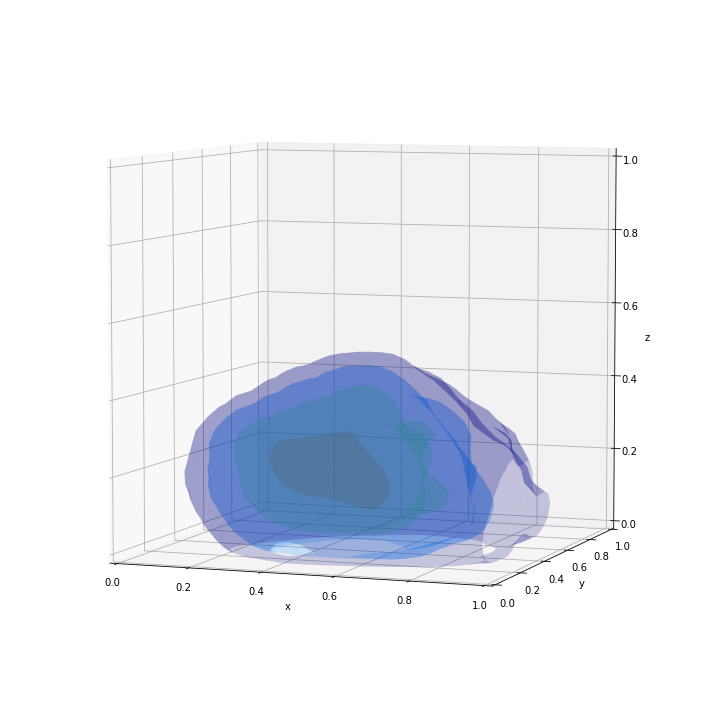

Starting marching cubes at density 0.082092 / (out off max 82.091718)
Starting marching cubes at density 0.820917 / (out off max 82.091718)
Starting marching cubes at density 8.209172 / (out off max 82.091718)
Starting marching cubes at density 41.045859 / (out off max 82.091718)


In [20]:
%matplotlib notebook
# Histograms
score_history = all_scores.numpy()
keep_frac = 1.0
keep_iters = int(len(score_history)*keep_frac)
print("Keeping history of %d iters." % keep_iters)
score_history = score_history[-keep_iters:]
# Normalize scores
score_history -= logsumexp(score_history)
score_history = np.exp(score_history)

R_history = all_Rs[-keep_iters:]
R_vec_history = torch.bmm(
    R_history,
    torch.tensor([1., 0., 0.]).unsqueeze(0).unsqueeze(-1).repeat(R_history.shape[0], 1, 1)
).squeeze().numpy()
t_history = all_ts.numpy()[-keep_iters:]
S_history = all_Ss.numpy()[-keep_iters:]
# Sort shape into ascending order 
S_history = np.sort(S_history, axis=1)[:, ::-1]
mins = np.array([0., 0.0, 0.])
maxes = np.array([1., 1., 1.])
num_samples = np.array([30, 30, 30])
plot_kde(R_history, R_vec_history,
         t_history, S_history,
         score_history,
         mins, maxes, num_samples)